# Fine-tuning Deep Learning models
When possible, it is a good idea to fine-tune existing CNN that have been pre-trained on large dataset. This can be done when the dataset under consideration is similar in context to the dataset that has been used to pre-train the model. We can then used a state of the art CNN that has already learned features that are relevant to our own deep learning task. We are then only left with calculating the bottleneck features of the pre-trained CNN and fine-tuned the pre-trained weights.

In the following, we use the ResNet50 deep learning model. The model is available in keras along with its weights pre-trained on the [ImageNet](http://www.image-net.org/) dataset, a collection of 1.2M labeled images of 1000 object categories.

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, y_train = load_dataset('dogImages/train')
valid_files, y_valid = load_dataset('dogImages/valid')
test_files, y_test = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[4:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('Dog categories: %d' % len(dog_names))
print('Dog images: %d \n' % len(np.hstack([train_files, valid_files, test_files])))
print('Training dog images: %d' % len(train_files))
print('Validation dog images: %d' % len(valid_files))
print('Test dog images: %d' % len(test_files))

Dog categories: 133
Dog images: 8351 

Training dog images: 6680
Validation dog images: 835
Test dog images: 836


In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm_notebook

def path_to_image(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_image(img_paths):
    list_of_images = [path_to_image(img_path) for img_path in tqdm_notebook(img_paths)]
    return np.vstack(list_of_images)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
x_train = paths_to_image(train_files).astype('float32')/255
x_valid = paths_to_image(valid_files).astype('float32')/255
x_test = paths_to_image(test_files).astype('float32')/255

HBox(children=(IntProgress(value=0, max=6680), HTML(value='')))

HBox(children=(IntProgress(value=0, max=835), HTML(value='')))

HBox(children=(IntProgress(value=0, max=836), HTML(value='')))

In [4]:
from keras.applications.resnet50 import ResNet50

ResNet50_truncated = ResNet50(weights='imagenet', include_top=False)
ResNet50_truncated.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [5]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

addon = ResNet50_truncated.output
# add a drop out layer
addon = Dropout(0.3)(addon)
# add a global spatial average pooling layer
addon = GlobalAveragePooling2D()(addon)
# let's add a fully-connected layer
addon = Dense(512, activation='relu')(addon)
# and a logistic layer -- 133 classes
predictions = Dense(133, activation='softmax')(addon)

In [6]:
from keras.models import Model

model = Model(inputs=ResNet50_truncated.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet50 layers
for layer in ResNet50_truncated.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# fit
model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
          epochs = 15, batch_size = 32, verbose = 1)

Train on 6680 samples, validate on 835 samples
Epoch 1/15
6680/6680 [==============================] - 70s 10ms/step - loss: 2.8685 - acc: 0.3207 - val_loss: 6.8232 - val_acc: 0.0096
Epoch 2/15
6680/6680 [==============================] - 69s 10ms/step - loss: 1.2610 - acc: 0.6268 - val_loss: 8.1386 - val_acc: 0.0120
Epoch 3/15
6680/6680 [==============================] - 69s 10ms/step - loss: 0.8999 - acc: 0.7210 - val_loss: 6.8393 - val_acc: 0.0623
Epoch 4/15
6680/6680 [==============================] - 69s 10ms/step - loss: 0.6771 - acc: 0.7844 - val_loss: 3.8715 - val_acc: 0.3030
Epoch 5/15
6680/6680 [==============================] - 69s 10ms/step - loss: 0.5497 - acc: 0.8237 - val_loss: 2.0993 - val_acc: 0.5473
Epoch 6/15
6680/6680 [==============================] - 69s 10ms/step - loss: 0.4568 - acc: 0.8481 - val_loss: 1.4454 - val_acc: 0.6479
Epoch 7/15
6680/6680 [==============================] - 69s 10ms/step - loss: 0.4025 - acc: 0.8696 - val_loss: 1.5882 - val_acc: 0.6551
E

In [7]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(ResNet50_truncated.layers):
   print(i, layer.name)

0 input_1
1 conv1
2 bn_conv1
3 activation_1
4 max_pooling2d_1
5 res2a_branch2a
6 bn2a_branch2a
7 activation_2
8 res2a_branch2b
9 bn2a_branch2b
10 activation_3
11 res2a_branch2c
12 res2a_branch1
13 bn2a_branch2c
14 bn2a_branch1
15 add_1
16 activation_4
17 res2b_branch2a
18 bn2b_branch2a
19 activation_5
20 res2b_branch2b
21 bn2b_branch2b
22 activation_6
23 res2b_branch2c
24 bn2b_branch2c
25 add_2
26 activation_7
27 res2c_branch2a
28 bn2c_branch2a
29 activation_8
30 res2c_branch2b
31 bn2c_branch2b
32 activation_9
33 res2c_branch2c
34 bn2c_branch2c
35 add_3
36 activation_10
37 res3a_branch2a
38 bn3a_branch2a
39 activation_11
40 res3a_branch2b
41 bn3a_branch2b
42 activation_12
43 res3a_branch2c
44 res3a_branch1
45 bn3a_branch2c
46 bn3a_branch1
47 add_4
48 activation_13
49 res3b_branch2a
50 bn3b_branch2a
51 activation_14
52 res3b_branch2b
53 bn3b_branch2b
54 activation_15
55 res3b_branch2c
56 bn3b_branch2c
57 add_5
58 activation_16
59 res3c_branch2a
60 bn3c_branch2a
61 activation_17
62 res3c

In [8]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[161:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD

opt = SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, History

checkpointer = ModelCheckpoint(filepath='dog.best.hdf5', verbose=1, save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
fit = History()

model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=32, 
          callbacks=[checkpointer,checkimprovement,fit], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 76s 11ms/step - loss: 0.1609 - acc: 0.9506 - val_loss: 1.7680 - val_acc: 0.6695
Epoch 2/100
6680/6680 [==============================] - 73s 11ms/step - loss: 0.1026 - acc: 0.9675 - val_loss: 1.6662 - val_acc: 0.6766
Epoch 3/100
6680/6680 [==============================] - 74s 11ms/step - loss: 0.0771 - acc: 0.9735 - val_loss: 1.6096 - val_acc: 0.6862
Epoch 4/100
6680/6680 [==============================] - 74s 11ms/step - loss: 0.0782 - acc: 0.9738 - val_loss: 1.5707 - val_acc: 0.6970
Epoch 5/100
6680/6680 [==============================] - 74s 11ms/step - loss: 0.0598 - acc: 0.9804 - val_loss: 1.5597 - val_acc: 0.6982
Epoch 6/100
6680/6680 [==============================] - 75s 11ms/step - loss: 0.0581 - acc: 0.9786 - val_loss: 1.5398 - val_acc: 0.7030
Epoch 7/100
6680/6680 [==============================] - 75s 11ms/step - loss: 0.0551 - acc: 0.9807 - val_loss: 1.5355 - val_acc: 0

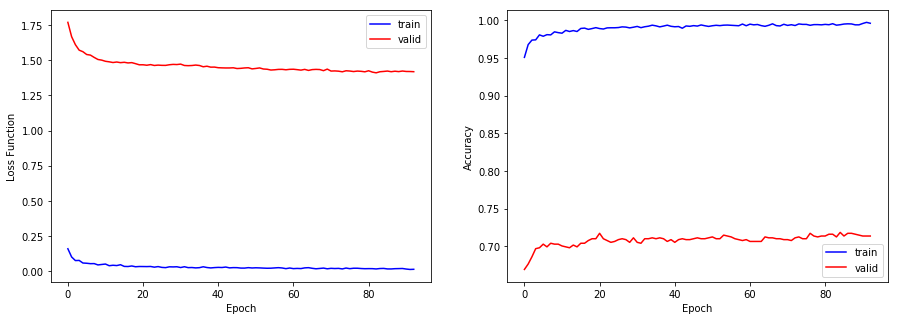

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def history(fit):
    plt.figure(figsize = (15, 5) )
    
    plt.subplot(121)
    plt.plot(fit.history['loss'], color = 'blue', label = 'train')
    plt.plot(fit.history['val_loss'], color = 'red', label = 'valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    
    plt.subplot(122)
    plt.plot(fit.history['acc'], color = 'blue', label = 'train')
    plt.plot(fit.history['val_acc'], color = 'red', label = 'valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
history(fit)

In [11]:
# load model
model.load_weights('dog.best.hdf5')

from sklearn.metrics import accuracy_score

y_pred = [np.argmax(y_hat) for y_hat in model.predict(x_test)]
y_true = [np.argmax(y) for y in y_test]
print('Test accuracy: %.2f%%' % (accuracy_score(y_true, y_pred)*100))

Test accuracy: 73.56%
